# Error analysis

## Load test data and predictions

In [ ]:
import ast
import datasets
from functools import partial

import pandas as pd


predictions = pd.read_csv('labeled_dataset.csv', index_col=0)
all_datasets = datasets.load_dataset('tner/tweetner7', cache_dir='data')
test_dataset = datasets.concatenate_datasets([all_datasets['test_2020'], all_datasets['test_2021']])


label_2_id = {
                 "B-corporation": 0,
                 "B-creative_work": 1,
                 "B-event": 2,
                 "B-group": 3,
                 "B-location": 4,
                 "B-person": 5,
                 "B-product": 6,
                 "I-corporation": 7,
                 "I-creative_work": 8,
                 "I-event": 9,
                 "I-group": 10,
                 "I-location": 11,
                 "I-person": 12,
                 "I-product": 13,
                 "O": 14
             }

id_2_label = {v: k for k, v in label_2_id.items()}

def to_bio(row, labels_mapping: dict):
    bio_labels = []
    for label in row['tags']:
        bio_labels.append(labels_mapping[label])
    row['bio_labels'] = bio_labels
    return row

converter_fn = partial(to_bio, labels_mapping=id_2_label)
test_dataset = pd.DataFrame(test_dataset.map(converter_fn))

assert all(test_dataset.id.apply(int) == predictions.id.apply(int))

In [38]:
test_dataset['pred_labels'] = predictions.NER_labels.apply(ast.literal_eval)
test_dataset.head(3)

,tokens,tags,id,date,bio_labels,pred_labels
0,"[Hanging, out, with, the, #, Popinboyz, and, i...","[14, 14, 14, 14, 14, 3, 14, 14, 14, 14, 14, 14...",1224056835298250758,2020-02-02,"[O, O, O, O, O, B-group, O, O, O, O, O, O, O, ...","[O, O, O, O, O, B-group, O, O, O, O, O, O, O, ..."
1,"["", It, 's, not, a, question, of, knowing, rig...","[14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 1...",1273251723398623232,2020-06-17,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2,"[{{URL}}, presents, {{USERNAME}}, at, the, ven...","[14, 14, 14, 14, 14, 14, 14, 2, 9, 9, 9, 9, 14...",1224029146206167044,2020-02-02,"[O, O, O, O, O, O, O, B-event, I-event, I-even...","[O, O, O, O, O, O, O, B-event, I-location, I-l..."


## Errors under a microscope

In [ ]:
def error_example(data: pd.DataFrame, category: str, n_examples: int = 5):
    true = data.bio_labels.apply(lambda x: f'B-{category}' in x)
    positive = data.pred_labels.apply(lambda x: f'B-{category}' in x)

    for title, examples in zip(
        [f'Unrecognized {category} entities',
         f'Falsely recognized  {category} entities'],
        [data[true & ~positive], data[~true & positive]]
    ):
        print(f'\033[1m{title}\033[0;0m:\n')
        examples = examples[:n_examples]
        for example in range(min(n_examples, len(examples))):
              print(
                pd.DataFrame(
                    {
                        'tokens:': examples.tokens.iloc[example],
                        'true  :': examples.bio_labels.iloc[example],
                        'pred  :': examples.pred_labels.iloc[example],
                        # 'raw   :': examples.raw_predictions.iloc[example]

                    } 
                )
                .transpose()
                .to_string(index=True, header=False),
                '\n'
            )


In [73]:
error_example(data=test_dataset, category='group', n_examples=3)

Unrecognized group entities:

tokens:  {{URL}}  presents  {{USERNAME}}  at  the  venue  for     Prog          in         the        Park      2.0  {{URL}}  via  {@YouTube@}  Do  n't  just  take  my  word  about  how  braw  {@Fife Council@}         The        Glen    Pavilion  is  {{USERNAME}}
true  :        O         O             O   O    O      O    O  B-event     I-event     I-event     I-event  I-event        O    O    B-product   O    O     O     O   O     O      O    O     O           B-group  B-location  I-location  I-location   O             O
pred  :        O         O             O   O    O      O    O  B-event  I-location  I-location  I-location        O        O    O    B-product   O    O     O     O   O     O      O    O     O     B-corporation           O  B-location  I-location   O             O 

tokens:     Tyson      Fury  dominates   Deontay    Wilder  to  become  heavyweight  champion  again  {{URL}}  via  {@NBC News@}
true  :  B-person  I-person          O  B-perso

## Token mismatch investigation

Our model identifies **ZERO WIDTH SPACE** (\u2066) as a token and classifies it as well, as opposed to ground truth labels.

This sometimes results in mismatched lengths of predicted and true labels.


*ZERO WIDTH SPACE - character intended for invisible word separation and for line break control; it has no width, but its presence between two characters does not prevent increased letter spacing in justification*

In [67]:
print(all(test_dataset.tokens.apply(len) == test_dataset.bio_labels.apply(len)))
print(all(test_dataset.tokens.apply(len) == test_dataset.pred_labels.apply(len)))

token_mistmatch = test_dataset.tokens.apply(len) != test_dataset.pred_labels.apply(len)

True
False


In [ ]:
for _, example in test_dataset[token_mistmatch].iterrows():
        print(

                f'tokens: {example.tokens}\n',
                f'true  : {example.bio_labels}\n',
                f'pred  : {example.pred_labels}\n',

        )

tokens: ['CC', ':', '\u2066', '{@Supervisor Catherine Stefani@}', '\u2069', 'Search', 'for', 'Armed', 'Suspect', '(', 'Marina', ',', 'San', 'Francisco', ')', 'Live', 'on', '{{USERNAME}}', '{{URL}}']
 true  : ['O', 'O', 'O', 'B-person', 'O', 'O', 'O', 'O', 'O', 'O', 'B-location', 'O', 'B-location', 'I-location', 'O', 'O', 'O', 'O', 'O']
 pred  : ['O', 'O', 'B-person', 'B-creative_work', 'O', 'I-creative_work', 'I-creative_work', 'O', 'B-location', 'I-location', 'I-location', 'I-location', 'O', 'O', 'O', 'O', 'O']

tokens: ['‘', 'Trump', 'vs', 'Biden', ':', 'The', 'Results’', 'this', 'Tuesday', 'w', '/', '\u2066', '{@tom bradby@}', '\u2069', '.', 'I', 'really', 'ca', 'n’t', 'overstate', 'the', 'importance', 'of', 'this', 'election', '.', 'I', '’ll', 'be', 'in', 'the', 'London', 'studio', 'analysing', 'the', 'results', 'with', '\u2066\u2066', '{{USERNAME}}', 'in', 'the', 'US', '\u2069', '.', 'Big', 'week', 'for', 'us', 'all', '.', 'Stay', 'safe', '.', '{{URL}}']
 true  : ['O', 'B-person',

## Label confusion

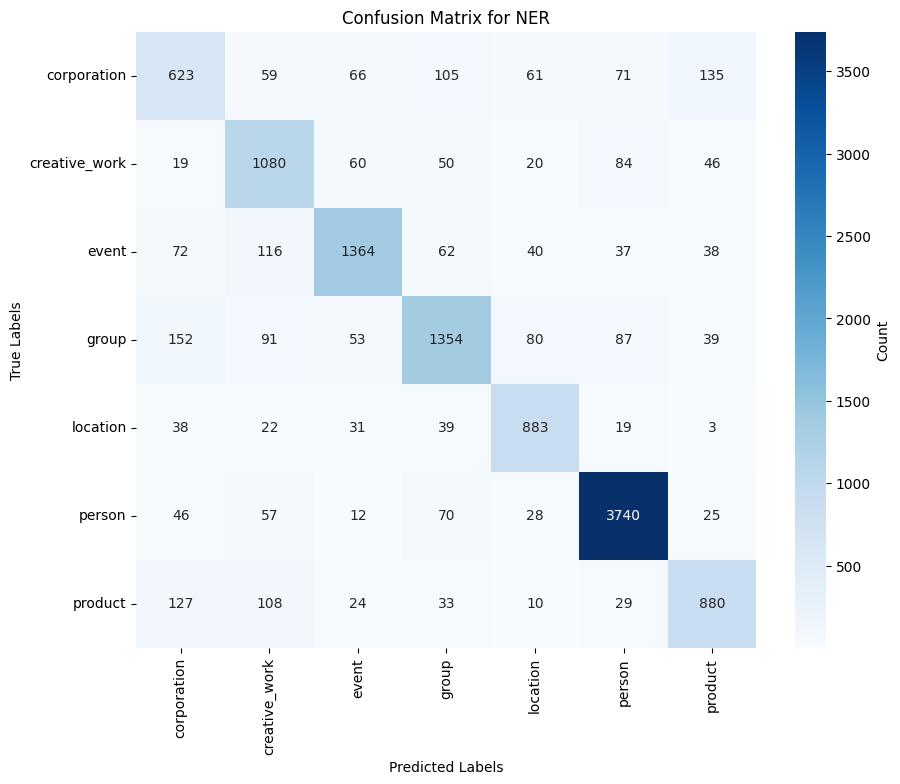

In [ ]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

flatten_tag = lambda tag: tag if tag == 'O' else tag.split('-')[-1]
flattened_true = [flatten_tag(tag) for sentence in test_dataset[~token_mistmatch].bio_labels for tag in sentence]
flattened_pred = [flatten_tag(tag) for sentence in test_dataset[~token_mistmatch].pred_labels for tag in sentence]

labels = sorted(set(flattened_true) | set(flattened_pred))
labels.remove('O')
conf_matrix = confusion_matrix(flattened_true, flattened_pred, labels=labels)

conf_matrix_df = pd.DataFrame(conf_matrix, index=labels, columns=labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix for NER')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()



## Conclusion

The model frequently misclassifies B-corporation entities as B-product or B-creative_work. Corporations are often presented in contexts that could allow confusion with products or creative works, particularly in tech and entertainment domains. Names that can serve as both a person and a corporate entity in different contexts are also problematic.

The model may not effectively identify event entities when presented in non-standard or abbreviated forms, especially in hashtags or compound words. 

Contextual cues for event recognition are not robust enough to correctly identify abstract or thematic events without clear textual markers.

Model has the tendency to default to corporation for organizational terms, especially when lacking clear indicators differentiating groups from corporations.

Pluralized person names can be wrongly interpreted as groups, especially when they reference known collectives or activities they oversee.

Occasionally, the model fails to correctly identify the start and end of entities, especially when they are part of longer token sequences or mixed with other entity types.